In [1]:
import pandas as pd
import numpy as np
from cartopy import crs as ccrs
import matplotlib.pyplot as plt

In [2]:
# Options to print figures into notebook/increase size
plt.rcParams.update({'font.size': 16, 'figure.figsize': [12, 6]})

In [3]:
fires = pd.read_csv("data/VIIRSNDE_global2018312.v1.0.txt")
fires.head()

,Lon,Lat,Mask,Conf,brt_t13(K),frp(MW),line,sample,Sat,YearDay,Hour
0,27.110006,30.769241,8,52,302.877533,5.814295,242,1735,NDE,2018312,1
1,26.083252,30.534357,9,100,332.959717,24.340988,301,1620,NDE,2018312,1
2,34.865997,28.162659,8,38,301.165985,6.107953,396,2589,NDE,2018312,1
3,34.872623,28.161121,8,71,307.277985,9.287819,396,2590,NDE,2018312,1
4,34.865070,28.158880,8,39,301.227783,6.001442,402,2590,NDE,2018312,1


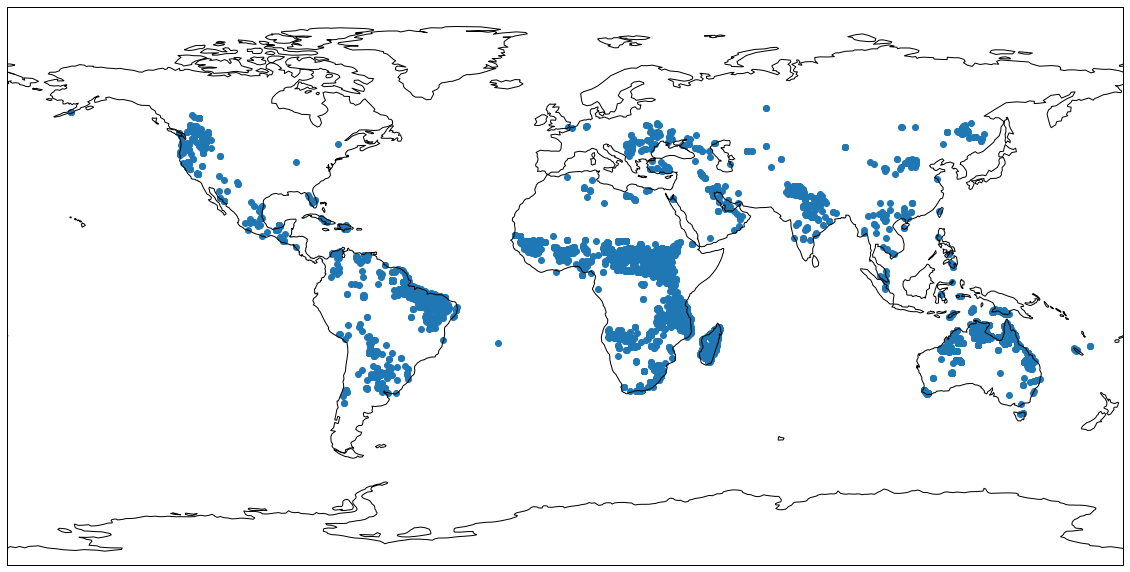

In [4]:
fig = plt.figure(figsize=[20,20])

ax = plt.subplot(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()

plt.scatter(fires['Lon'], fires['Lat'])
plt.show()

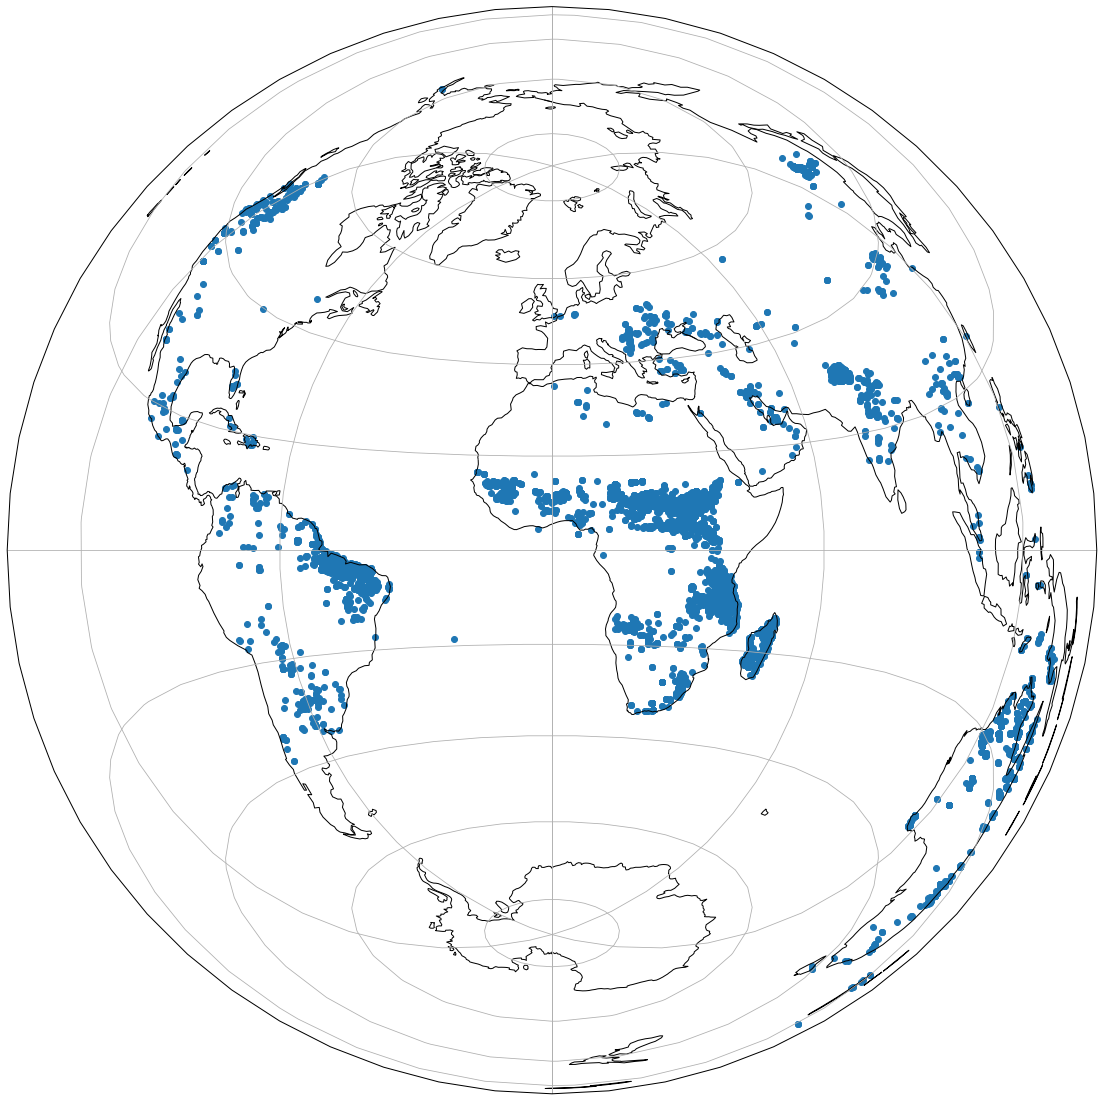

In [5]:
fig = plt.figure(figsize=[20,20])

ax = plt.subplot(projection=ccrs.LambertAzimuthalEqualArea())

ax.coastlines()
ax.gridlines()
ax.set_global()

plt.scatter(fires['Lon'], fires['Lat'], transform=ccrs.PlateCarree())
plt.show()

In [6]:
extent = [-125, -120, 38, 44]

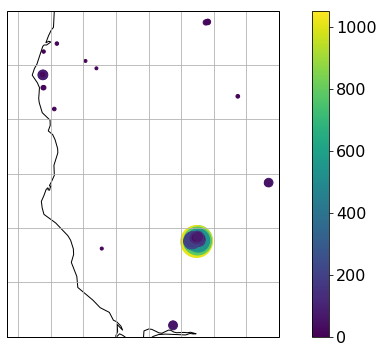

In [7]:
fig = plt.figure()

ax=plt.subplot(projection=ccrs.PlateCarree())

ax.set_extent(extent)
ax.gridlines()

ax.coastlines('50m')
plt.scatter(fires['Lon'], fires['Lat'], c=fires['frp(MW)'],
    s=fires['frp(MW)'], transform=ccrs.PlateCarree())

plt.colorbar()

plt.show()

In [38]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib import ticker

In [39]:
to_proj = ccrs.PlateCarree()
from_proj = ccrs.PlateCarree()

lonLabels = np.arange(-180, 180, 1.5)
latLabels = np.arange(-90, 90, 1)

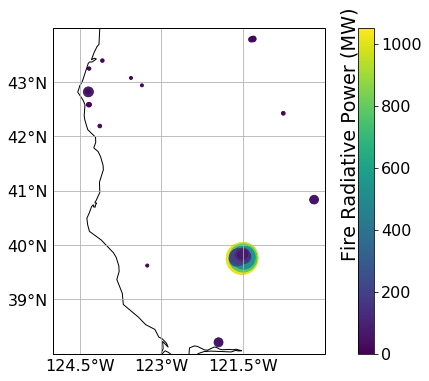

In [46]:
fig = plt.figure()
ax = plt.subplot(projection=to_proj)

ax.coastlines('50m')
ax.set_extent(extent)

frp = ax.scatter(fires['Lon'], fires['Lat'], c=fires['frp(MW)'],
    s=fires['frp(MW)'], transform=from_proj)
cbar = plt.colorbar(frp)
cbar.ax.set_title("Fire Radiative Power (MW)", rotation='vertical', x=-0.5)

# 1) Maps the gridlines to the variable gl
gl = ax.gridlines(crs=to_proj, draw_labels=True)

# 2) Adds two attributes to gl, which are xlocator and ylocator
gl.xlocator = ticker.FixedLocator(lonLabels)
gl.ylocator = ticker.FixedLocator(latLabels)

# 3) Changes labels to show degrees North/South and East/West
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# 4) Removed labels from top and right side
# comment out if you want to include
gl.xlabels_top = False
gl.ylabels_right = False

plt.show()

In [11]:
from netCDF4 import Dataset

fname='data/JRR-AOD_v1r1_npp_s201808091955538_e201808091957180_c201808092049460.nc'
file_id = Dataset(fname)
file_id.variables.keys()

odict_keys(['Latitude', 'Longitude', 'StartRow', 'StartColumn', 'AOD550', 'AOD_channel', 'AngsExp1', 'AngsExp2', 'QCPath', 'AerMdl', 'FineMdlIdx', 'CoarseMdlIdx', 'FineModWgt', 'SfcRefl', 'SpaStddev', 'Residual', 'AOD550LndMdl', 'ResLndMdl', 'MeanAOD', 'HighQualityPct', 'RetrievalPct', 'QCRet', 'QCExtn', 'QCTest', 'QCInput', 'QCAll'])

In [12]:
print(file_id.variables['AOD550'].shape, 
      file_id.variables['Latitude'].shape,
      file_id.variables['Longitude'].shape)

(768, 3200) (768, 3200) (768, 3200)


In [13]:
aod = file_id.variables['AOD550'][:,:]
lat = file_id.variables['Latitude'][:,:]
lon = file_id.variables['Longitude'][:,:]

In [14]:
print(file_id.variables['AOD550'].valid_range)

[-0.05  5.  ]


In [15]:
levs = np.arange(0, 1.8, 0.1)
levs

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7])

In [20]:
central_lon = np.mean(extent[0:2])

to_proj = ccrs.EquidistantConic(central_longitude=central_lon)
from_proj = ccrs.PlateCarree()

In [60]:
mask = (lon < extent[0]) & (lon > extent[1])

masked_lon = np.ma.array(lon, mask=mask)
masked_lat = np.ma.array(lat, mask=mask)
masked_aod = np.ma.array(aod, mask=mask)

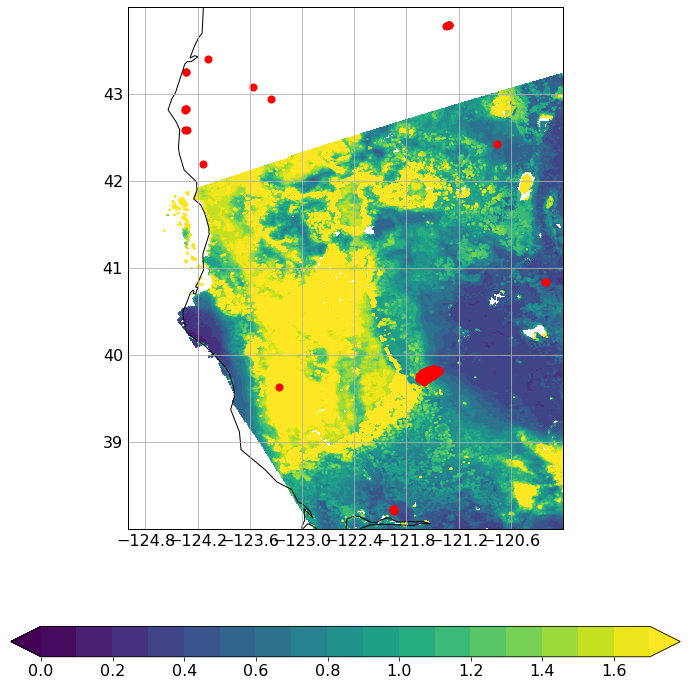

In [77]:
fig = plt.figure(figsize=[12, 12])
ax = plt.subplot(projection=to_proj)

ax.coastlines('50m')
ax.set_extent(extent)

x1 = plt.contourf(masked_lon, masked_lat, masked_aod, levs, extend='both')

fig.colorbar(x1, extend='both',
    orientation="horizontal", fraction=0.05)

gl = ax.gridlines(crs=to_proj, draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False

# Adds the active fire scatter plot on top
plt.scatter(fires['Lon'], fires['Lat'], color='red', s=50,
    transform=from_proj)

plt.show()

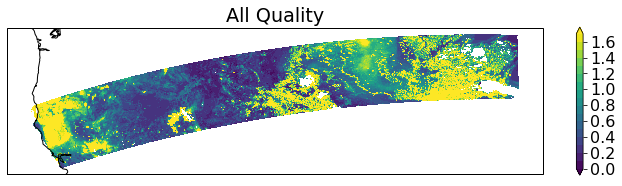

In [47]:
fig = plt.figure()

upper_axis = fig.add_subplot(2,1,1, projection=ccrs.PlateCarree())
upper_axis.coastlines('50m')0

upper_fig = upper_axis.contourf(lon, lat, aod, levs, extend='both')
fig.colorbar(upper_fig, ax=upper_axis, extend='both')
plt.show()

In [72]:
# Import quality flag
quality_flag = file_id.variables['QCAll'][:,:]

# Keep all but the "best" quality using masked arrays
maskHQ = (quality_flag != 0)
aodHQ = np.ma.masked_where(maskHQ, aod)

In [74]:
(aod.count()-aodHQ.count())/aod.count()

0.33269544384282035

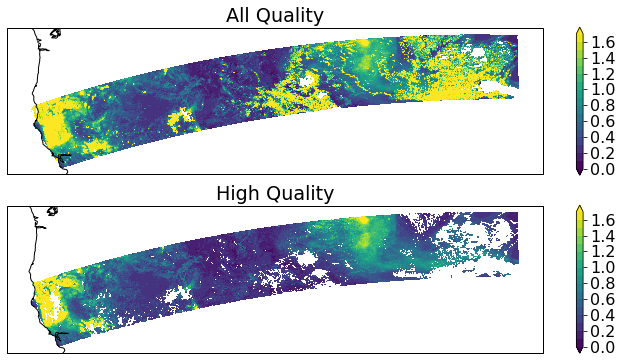

In [76]:
# Top plot
fig = plt.figure()

upper_axis = plt.subplot(2,1,1, projection=ccrs.PlateCarree())
upper_axis.set_title("All Quality")

upper_axis.coastlines('50m')

upper_fig = upper_axis.contourf(lon, lat, aod, levs, extend='both')
fig.colorbar(upper_fig, ax=upper_axis, extend='both')

# Bottom plot
lower_axis = plt.subplot(2,1,2, projection=ccrs.PlateCarree())
lower_axis.set_title("High Quality")

lower_axis.coastlines('50m')

lower_fig = lower_axis.contourf(lon, lat, aodHQ, levs, extend='both')
fig.colorbar(lower_fig, ax=lower_axis, extend='both')

plt.show()

In [79]:
fname='data/goes-meso/michael/OR_ABI-L1b-RadM1-M3C13_G16_s20182822019282_e20182822019350_c20182822019384.nc'
file_id = Dataset(fname)
list(file_id.variables)

['Rad',
 'DQF',
 't',
 'y',
 'x',
 'time_bounds',
 'goes_imager_projection',
 'y_image',
 'y_image_bounds',
 'x_image',
 'x_image_bounds',
 'nominal_satellite_subpoint_lat',
 'nominal_satellite_subpoint_lon',
 'nominal_satellite_height',
 'geospatial_lat_lon_extent',
 'yaw_flip_flag',
 'band_id',
 'band_wavelength',
 'esun',
 'kappa0',
 'planck_fk1',
 'planck_fk2',
 'planck_bc1',
 'planck_bc2',
 'valid_pixel_count',
 'missing_pixel_count',
 'saturated_pixel_count',
 'undersaturated_pixel_count',
 'min_radiance_value_of_valid_pixels',
 'max_radiance_value_of_valid_pixels',
 'mean_radiance_value_of_valid_pixels',
 'std_dev_radiance_value_of_valid_pixels',
 'percent_uncorrectable_L0_errors',
 'earth_sun_distance_anomaly_in_AU',
 'algorithm_dynamic_input_data_container',
 'processing_parm_version_container',
 'algorithm_product_version_container',
 't_star_look',
 'band_wavelength_star_look',
 'star_id']

In [20]:
file_id.variables['x'][0:10], file_id.variables['y'][0:10]

(masked_array(data = [-0.04424  -0.044184 -0.044128 -0.044072 -0.044016 -0.04396  -0.043904
  -0.043848 -0.043792 -0.043736],
              mask = False,
        fill_value = 1e+20),
 masked_array(data = [ 0.08848     0.088424    0.08836801  0.088312    0.088256    0.0882
   0.088144    0.08808801  0.088032    0.087976  ],
              mask = False,
        fill_value = 1e+20))

In [21]:
proj_var = file_id.variables['goes_imager_projection']
print(proj_var)

<class 'netCDF4._netCDF4.Variable'>
int32 goes_imager_projection()
    long_name: GOES-R ABI fixed grid projection
    grid_mapping_name: geostationary
    perspective_point_height: 35786023.0
    semi_major_axis: 6378137.0
    semi_minor_axis: 6356752.31414
    inverse_flattening: 298.2572221
    latitude_of_projection_origin: 0.0
    longitude_of_projection_origin: -75.0
    sweep_angle_axis: x
unlimited dimensions: 
current shape = ()
filling on, default _FillValue of -2147483647 used



In [22]:
# Define the satellite height and central longitude for plots
# Can vary depending on the geo satellite
sat_height = proj_var.perspective_point_height

# Multiply the x, y coordinated by satellite height to get the pixel position
X = file_id.variables['x'][:] * sat_height
Y = file_id.variables['y'][:] * sat_height

imgExtent = (X.min(), X.max(), Y.min(), Y.max())

# Get the radiance data
rad = file_id.variables['Rad'][:,:]

In [23]:
# Define the globe projection
semi_major = proj_var.semi_major_axis
semi_minor = proj_var.semi_minor_axis

globe = ccrs.Globe(semimajor_axis=semi_major, semiminor_axis=semi_minor)

In [24]:
central_lon = proj_var.longitude_of_projection_origin

In [25]:
crs = ccrs.Geostationary(central_longitude=central_lon, satellite_height=sat_height, globe=globe)

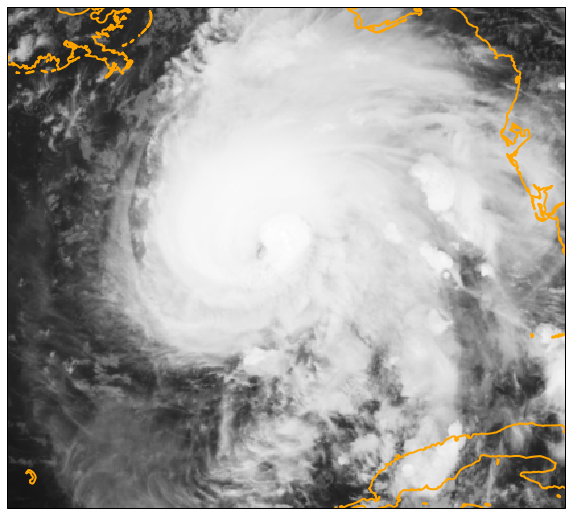

In [26]:
fig = plt.figure(figsize=(10,10))

ax = plt.subplot(projection=crs)
ax.coastlines('10m', color='orange', linewidth=2)
ax.set_extent([-90.0, -82.0, 22.0, 30.0])

ax.imshow(rad, origin='upper', cmap='gray_r', extent=imgExtent)

plt.show()

In [27]:
glmfname = 'data/GLM-L2-LCFA_2018_282_20_OR_GLM-L2-LCFA_G16_s20182822000200_e20182822000400_c20182822000427.nc'
file_id_glm = Dataset(glmfname)
file_id_glm.variables.keys()

odict_keys(['event_id', 'event_time_offset', 'event_lat', 'event_lon', 'event_energy', 'event_parent_group_id', 'group_id', 'group_time_offset', 'group_lat', 'group_lon', 'group_area', 'group_energy', 'group_parent_flash_id', 'group_quality_flag', 'flash_id', 'flash_time_offset_of_first_event', 'flash_time_offset_of_last_event', 'flash_lat', 'flash_lon', 'flash_area', 'flash_energy', 'flash_quality_flag', 'product_time', 'product_time_bounds', 'lightning_wavelength', 'lightning_wavelength_bounds', 'group_time_threshold', 'flash_time_threshold', 'lat_field_of_view', 'lat_field_of_view_bounds', 'goes_lat_lon_projection', 'event_count', 'group_count', 'flash_count', 'percent_navigated_L1b_events', 'yaw_flip_flag', 'nominal_satellite_subpoint_lat', 'nominal_satellite_height', 'nominal_satellite_subpoint_lon', 'lon_field_of_view', 'lon_field_of_view_bounds', 'percent_uncorrectable_L0_errors', 'algorithm_dynamic_input_data_container', 'processing_parm_version_container', 'algorithm_product_v

In [28]:
glmLon = file_id_glm.variables['event_lon'][:]
glmLat = file_id_glm.variables['event_lat'][:]
area = file_id_glm.variables['event_energy'][:]

glmDF = pd.DataFrame({'lat': glmLat, 'lon': glmLon, 'area': area })

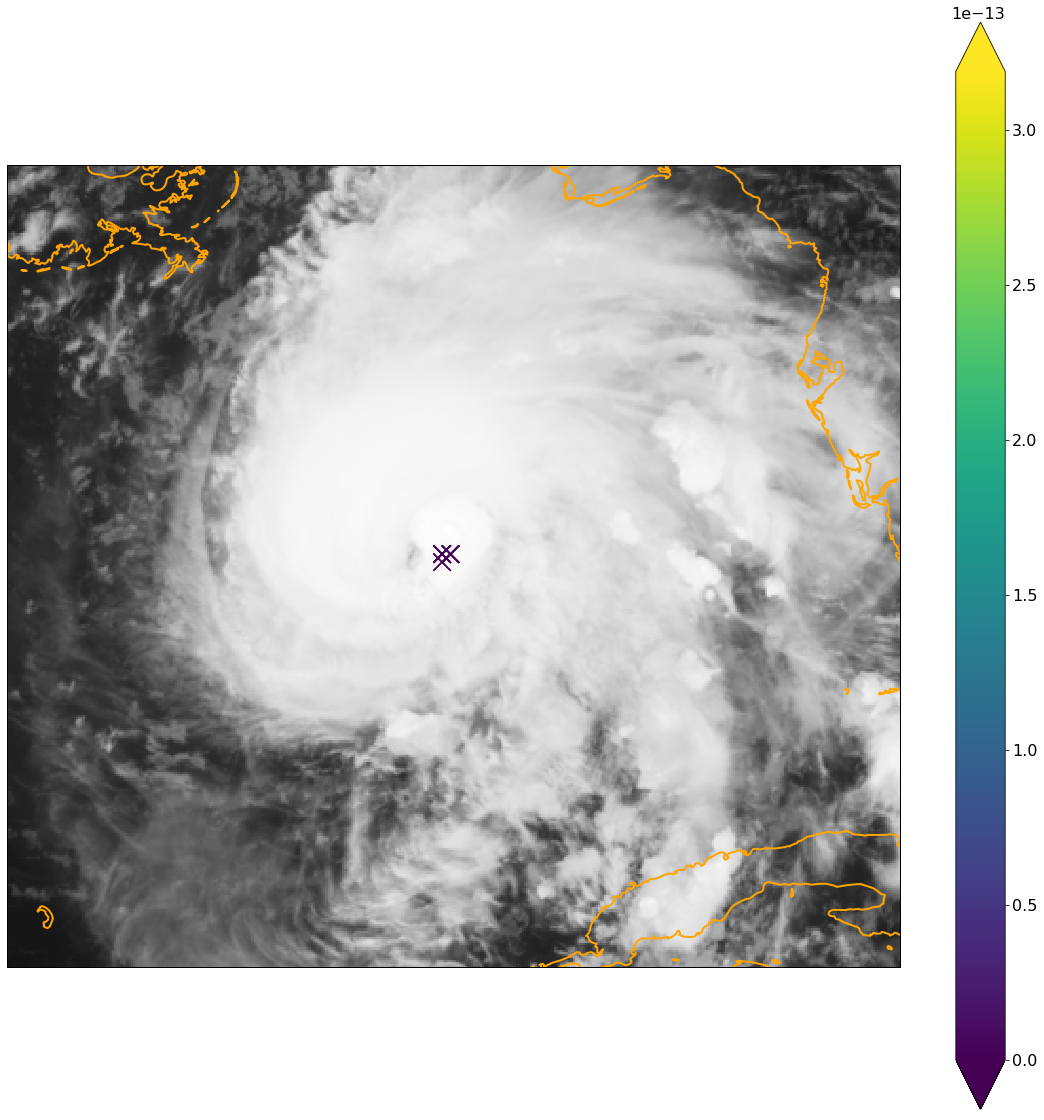

In [29]:
crs = ccrs.Geostationary(central_longitude=central_lon, satellite_height=sat_height, globe=globe)
from_proj

from_proj =  ccrs.PlateCarree()
plt.figure(figsize=[20,20])

ax = plt.subplot(projection=crs)
ax.coastlines('10m', color='orange', linewidth=2)
ax.set_extent([-90.0, -82.0, 22.0, 30.0])

# Plot ABI
ax.imshow(rad, origin='upper',cmap='gray_r', extent=imgExtent)

# Add GLM data
plt.scatter(glmDF.lon, glmDF.lat, c=glmDF.area, transform=from_proj,
    s = 300, marker='x')
plt.colorbar(extend='both')

plt.show()

In [30]:
# glmDF["LonBin"] = glmDF["lon"].round()
# glmDF["LatBin"] = glmDF["lat"].round()

# glmCount = glmDF.groupby(["LonBin", "LatBin"]).size()
# glmCount = glmCount.reset_index(name="Count")
# glm3D = glmCount.pivot(index='LatBin', columns='LonBin', values='Count')

# glmX, glmY = np.meshgrid(glm3D.columns, glm3D.index)

In [31]:
import cartopy.feature as cfeature
import xarray as xr

In [32]:
fname = 'data/NUCAPS-EDR_v2r0_npp_s201903031848390_e201903031849090_c201903031941100.nc'
nucaps = xr.open_dataset(fname, decode_times=False)
nucaps

<xarray.Dataset>
Dimensions:               (Number_of_Cloud_Emis_Hing_Pts: 100, Number_of_Cloud_Layers: 8, Number_of_CrIS_FORs: 120, Number_of_Ispares: 129, Number_of_MW_Spectral_Pts: 16, Number_of_P_Levels: 100, Number_of_Rspares: 262, Number_of_Stability_Parameters: 16, Number_of_Surf_Emis_Hinge_Pts: 100)
Coordinates:
    Time                  (Number_of_CrIS_FORs) float64 ...
    Latitude              (Number_of_CrIS_FORs) float32 ...
    Longitude             (Number_of_CrIS_FORs) float32 ...
    Pressure              (Number_of_CrIS_FORs, Number_of_P_Levels) float32 ...
    Effective_Pressure    (Number_of_CrIS_FORs, Number_of_P_Levels) float32 ...
Dimensions without coordinates: Number_of_Cloud_Emis_Hing_Pts, Number_of_Cloud_Layers, Number_of_CrIS_FORs, Number_of_Ispares, Number_of_MW_Spectral_Pts, Number_of_P_Levels, Number_of_Rspares, Number_of_Stability_Parameters, Number_of_Surf_Emis_Hinge_Pts
Data variables:
    quality_information   |S1 ...
    CrIS_FORs             (Number

In [33]:
# Make a dictionary with pressure levels and indices ...
pressureLevs = np.array(nucaps.sel(Number_of_CrIS_FORs=0).Pressure.values, dtype='i4')

In [34]:
df = nucaps['H2O_MR'].sel(Number_of_CrIS_FORs=range(0,29))
df = df.transpose('Number_of_P_Levels', 'Number_of_CrIS_FORs')

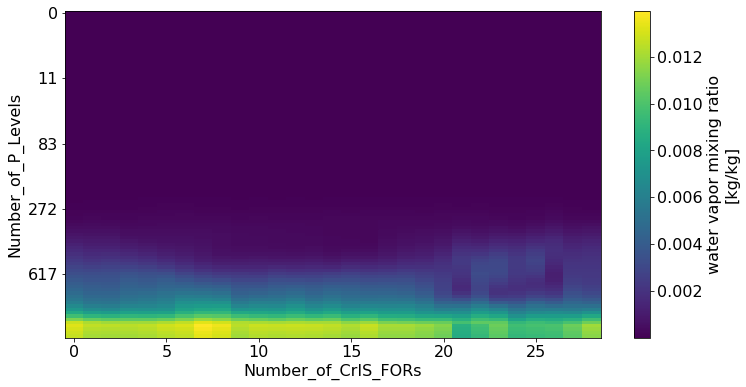

In [35]:
plt.figure()
#pcolormesh by default
df.plot(yincrease=False)
plt.yticks(nucaps.Number_of_P_Levels.values[::20], labels=pressureLevs[::20])
plt.show()

In [36]:
fname = 'data/SURFALB_v1r0_npp_s201906251121208_e201906251122449_c201906251208560.nc'
albedo = xr.open_dataset(fname, decode_times=False)

In [37]:
albedo

<xarray.Dataset>
Dimensions:                    (Columns: 3200, Rows: 768)
Coordinates:
    Latitude                   (Rows, Columns) float32 ...
    Longitude                  (Rows, Columns) float32 ...
Dimensions without coordinates: Columns, Rows
Data variables:
    StartRow                   int32 ...
    StartColumn                int32 ...
    VIIRS_Albedo_IP            (Rows, Columns) float32 ...
    VIIRS_Albedo_EDR           (Rows, Columns) float32 ...
    DataQualityFlag            (Rows, Columns) float32 ...
    ProductQualityInformation  (Rows, Columns) float32 ...
    AlbScl                     float32 ...
    AlbOff                     float32 ...
    OvQltyNoRtr                int32 ...
    OvQltyRtr                  int32 ...
    OvQltyHghQltyRtr           int32 ...
    CldConfClr                 int32 ...
    CldProbClr                 int32 ...
    CldProbCld                 int32 ...
    CldConfCld                 int32 ...
    RtrPthNoRtr                int32 ...


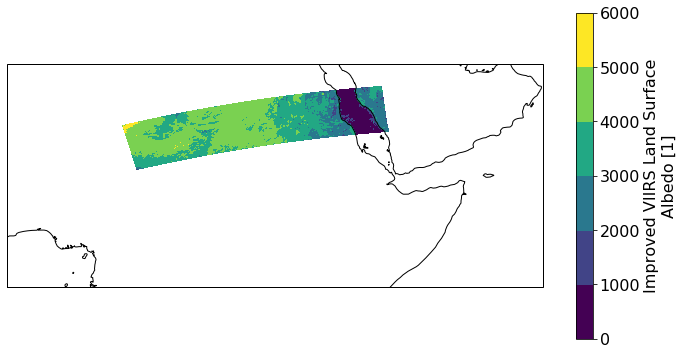

In [38]:
# Initiate the plot
ax = plt.subplot(projection=ccrs.PlateCarree());

ax.coastlines('50m')

# Plots the latitude and longitude of the NUCAPS data
albedo['VIIRS_Albedo_EDR'].plot.contourf('Longitude', 'Latitude', ax=ax, transform=ccrs.PlateCarree());

# Expands axes
ax.set_ylim(0, 25)
ax.set_xlim(0, 60)

# Display plot
plt.show()

In [39]:
baseURL = 'http://www.esrl.noaa.gov'
catalogURL = '/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc'
sstID = xr.open_dataset(baseURL+catalogURL)
sstID

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, nbnds: 2, time: 1995)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 80.0 78.0 76.0 74.0 72.0 ...
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 10.0 12.0 14.0 16.0 18.0 ...
  * time       (time) datetime64[ns] 1854-01-01 1854-02-01 1854-03-01 ...
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 ...
    sst        (time, lat, lon) float32 ...
Attributes:
    climatology:                     Climatology is based on 1971-2000 SST, X...
    description:                     In situ data: ICOADS2.5 before 2007 and ...
    keywords_vocabulary:             NASA Global Change Master Directory (GCM...
    keywords:                        Earth Science > Oceans > Ocean Temperatu...
    instrument:                      Conventional thermometers
    source_comment:                  SSTs were observed by conventional therm...
    geospatial_lon_min:              -1.0
    geospatial_lon_max

In [40]:
sst = sstID.sst
sst

<xarray.DataArray 'sst' (time: 1995, lat: 89, lon: 180)>
[31959900 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 78.0 76.0 74.0 72.0 70.0 ...
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 10.0 12.0 14.0 16.0 18.0 20.0 ...
  * time     (time) datetime64[ns] 1854-01-01 1854-02-01 1854-03-01 ...
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    dataset:       NOAA Extended Reconstructed SST V5
    parent_stat:   Individual Values
    actual_range:  [ -1.79999995  42.3263588 ]
    valid_range:   [ -1.79999995  45.        ]
    _ChunkSizes:   [  1  89 180]

In [41]:
mostRecent = len(sst.time.values)-1
recentSST = sst.isel(time=mostRecent)

In [42]:
sstmin = 0
sstmax = 30

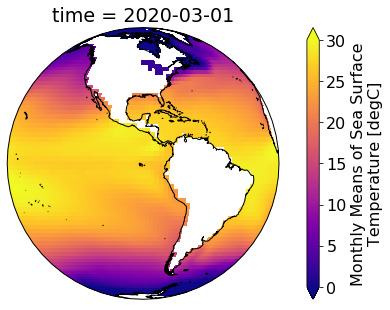

In [43]:
fig = plt.figure(figsize=[10,5])
ax = plt.subplot(projection=ccrs.Orthographic(-90, 0))
recentSST.plot(cmap=plt.get_cmap('plasma'),
    vmin=sstmin, vmax=sstmax, transform=ccrs.PlateCarree())
ax.coastlines('50m')
plt.show()

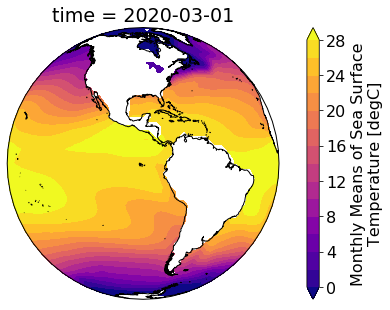

In [44]:
levels = np.arange(sstmin, sstmax, 2)

fig = plt.figure(figsize=[10,5])
ax = plt.subplot(projection=ccrs.Orthographic(-90, 0))
recentSST.plot.contourf(levels=levels, cmap=plt.get_cmap('plasma'), transform=ccrs.PlateCarree())
ax.coastlines('50m')
plt.show()